In [1]:
import os
os.chdir("../../")

import torch
import matplotlib.pyplot as plt
import numpy as np

from models.bs_class import Bs
from torch.distributions import Uniform

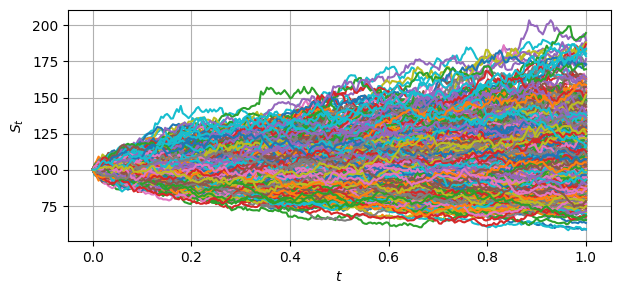

In [2]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
T = 1.0
S0 = torch.tensor(100.0)

mu_true = torch.tensor(0.1)
sigma_true = torch.tensor(0.2)

bs_model = Bs(mu_true, sigma_true)
S = bs_model.simulate(S0, dt, T, M=1000)

plt.figure(figsize=(7,3))
plt.plot(torch.linspace(0, T, len(S)), S.detach())
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.grid()
plt.show()

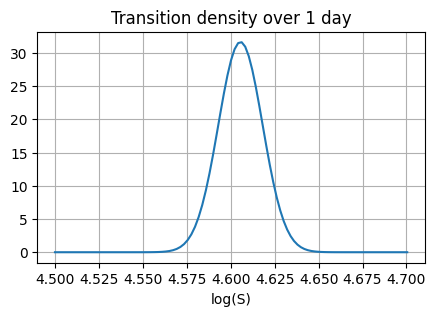

In [3]:
plt.figure(figsize=(5, 3))

S_next = torch.linspace(S0 - 10, S0 + 10, 100)
transition = torch.exp(bs_model.log_transition(S0, S_next, dt))
plt.plot(torch.log(S_next), transition.detach())
plt.grid()
plt.xlabel('log(S)')
plt.title(f'Transition density over {int(dt * 252)} day')
plt.show()

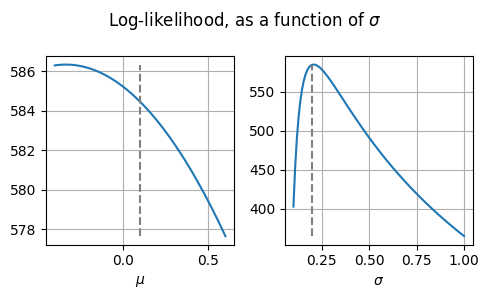

In [4]:
t = S.shape[0] - 1
spot = S[:, 0]

decay_coef = 1.0
window = 200

fig, axs = plt.subplots(figsize=(5, 3), nrows=1, ncols=2)

mus = torch.linspace(mu_true - 0.5, mu_true + 0.5, 50)
log_likelihood = torch.zeros_like(mus)
for i, mu in enumerate(mus):
    model = Bs(mu, sigma_true)
    log_likelihood[i] = model.forward(spot, t, delta_t=dt, decay_coef=decay_coef, window=window)
axs[0].plot(mus, log_likelihood.detach())
axs[0].vlines(mu_true, ymin=log_likelihood.min().detach(), ymax=log_likelihood.max().detach(), color='grey', linestyle='--')
axs[0].set_xlabel(r'$\mu$')
axs[0].grid()

sigmas = torch.linspace(0.1, 1.0, 100)
likelihood = torch.zeros_like(sigmas)
for i, sigma in enumerate(sigmas):
    model = Bs(mu_true, sigma)
    likelihood[i] = model.forward(spot, t, delta_t=dt, decay_coef=decay_coef, window=window)
axs[1].plot(sigmas, likelihood.detach(), label='log-likelihood')
axs[1].vlines(sigma_true, torch.min(likelihood.detach()), torch.max(likelihood.detach()), linestyles='dashed', colors='grey', label='true')
axs[1].set_xlabel(r'$\sigma$')
axs[1].grid()

fig.suptitle(rf'Log-likelihood, as a function of $\sigma$')
fig.tight_layout()

/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis/.venv/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


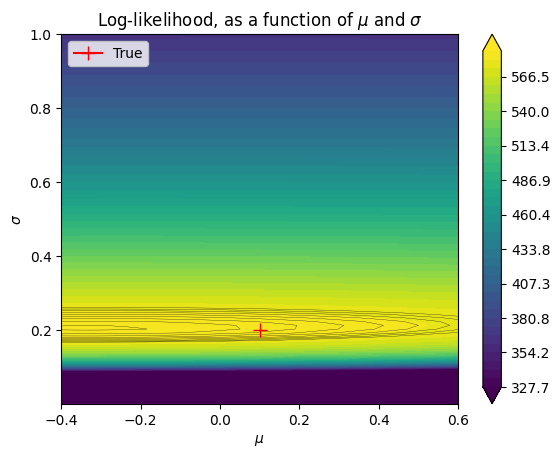

In [5]:
# Contour plot of the likelihood, as a function of alpha, beta
t = S.shape[0] - 1
spot = S[:, 0]

decay_coef = 1.0
window = 200

mus = torch.linspace(mu_true - 0.5, mu_true + 0.5, 100)
sigmas = torch.linspace(1e-4, 1.0, 100)
mus, sigmas = torch.meshgrid(mus, sigmas)
log_likelihood = torch.zeros(size=(100, 100))
for i in range(mus.shape[0]):
    for j in range(mus.shape[1]):
        model = Bs(mus[i, j], sigmas[i, j])
        log_likelihood[i, j] = model.forward(spot, t, delta_t=dt, decay_coef=decay_coef, window=window)

mean = torch.mean(log_likelihood).detach().item()
min = torch.min(log_likelihood).detach().item()
max = torch.max(log_likelihood).detach().item()
levels = np.linspace(mean - 2.0 , max, 40)

contour = plt.contourf(mus, sigmas, log_likelihood.detach(), levels=levels, cmap='viridis', extend='both')

levels = np.linspace(max - 10, max + 1, 10)
contour_line = plt.contour(mus, sigmas, log_likelihood.detach(), levels=levels, colors='black', linewidths=0.2)
plt.colorbar(contour)

marker_plot = plt.plot(mu_true.item(), sigma_true.item(), marker='+', color='red', markersize=10, label='True')
plt.legend(handles=marker_plot, loc='upper left')

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title(r'Log-likelihood, as a function of $\mu$ and $\sigma$')
plt.show()

In [6]:
torch.manual_seed(42)
t = S.shape[0] - 1

decay_coef = 1.0
window = 200

n_paths = S.shape[1]
n_params = 2
stats = {
    "mle": torch.zeros(size=(n_paths, n_params)),
    "max_value": torch.zeros(size=(n_paths,)),
    "n_it": torch.zeros(size=(n_paths,)),
    "no_convergence": 0,
}

max_it = 1000
grad_norm_threshold = 1e-3
for i in range(n_paths):
    print(i)
    mu = Uniform(low=-0.5, high=0.5).sample()
    sigma = Uniform(low=1e-4, high=1.0).sample()
    #print("Init: ", sigma.item())

    model = Bs(mu, sigma)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, maximize=True)
    spot_prices = S[:, i]
    for j in range(max_it):
        optimizer.zero_grad()
        loss = model.forward(spot_prices, t=t, delta_t=dt, decay_coef=decay_coef, window=window)
        loss.backward()
        total_norm = torch.norm(torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None]))
    
        #print(f"Epoch {j}, Loss: {loss.item():.3f}, Grad Norm: {total_norm.item():.3f}")
        if total_norm < grad_norm_threshold:
            stats["n_it"][i] = j
            break
        if j == max_it - 1:
            stats["n_it"][i] = j
            stats["no_convergence"] += 1
            print("Maximum iteration reached.")
        optimizer.step()

    params = model.get_params()
    stats["mle"][i, 0] = params['mu']
    stats["mle"][i, 1] = params['sigma']

    model = Bs(params['mu'], params['sigma'])
    value = model.forward(spot_prices, t=t, delta_t=dt, decay_coef=decay_coef, window=window)
    stats["max_value"][i] = value

0
1
2
3
4
5
6
7
8
9
Maximum iteration reached.
10
Maximum iteration reached.
11
12
13
14
15
16
17
18
19
20
21
22
23
Maximum iteration reached.
24
25
26
27
28
Maximum iteration reached.
29
30
31
Maximum iteration reached.
32
33
34
Maximum iteration reached.
35
36
37
38
39
Maximum iteration reached.
40
41
42
43
44
Maximum iteration reached.
45
46
Maximum iteration reached.
47
48
49
50
51
52
53
54
55
Maximum iteration reached.
56
57
58
59
60
61
62
63
Maximum iteration reached.
64
65
66
67
Maximum iteration reached.
68
69
70
71
72
73
74
75
Maximum iteration reached.
76
77
78
79
80
81
82
83
84
85
86
87
88
Maximum iteration reached.
89
90
91
92
Maximum iteration reached.
93
94
95
96
97
98
99
100
101
102
103
104
105
Maximum iteration reached.
106
Maximum iteration reached.
107
108
109
110
Maximum iteration reached.
111
112
113
Maximum iteration reached.
114
115
116
Maximum iteration reached.
117
118
Maximum iteration reached.
119
120
121
122
123
124
125
Maximum iteration reached.
126
127
Maxi

In [7]:
mean = torch.mean(stats["mle"], dim=0)
std = torch.std(stats["mle"], dim=0)
avg_it = torch.mean(stats["n_it"])
n_no_conv = stats["no_convergence"]

true_params = torch.tensor([mu_true.item(), sigma_true.item()])
avg_distance_to_argmax = torch.mean(torch.norm(stats["mle"] - true_params))

true_max_value = Bs(mu_true, sigma_true).forward(spot_prices, t=t, delta_t=dt, decay_coef=decay_coef, window=window).item()
avg_distance_to_max = torch.mean(torch.abs(stats["max_value"] - true_max_value)).item()

print(f"Average MLE: mu:{mean[0].item():.3f}, sigma:{mean[1].item():.3f}")
print(f"Std MLE: mu:{std[0].item():.3f}, sigma:{std[1].item():.3f}")
print(f"Average distance to true parameter: {avg_distance_to_argmax.item():.3f}")
print(f"Average relative error to the true maximum: {((true_max_value - avg_distance_to_max) / true_max_value):.3f}")
print(f"Average number of iteration to convergence {avg_it.item():.3f}")
print(f"Number of parameters where GD didn't converge: {n_no_conv}")

Average MLE: mu:0.097, sigma:0.200
Std MLE: mu:0.227, sigma:0.010
Average distance to true parameter: 7.197
Average relative error to the true maximum: 0.974
Average number of iteration to convergence 324.942
Number of parameters where GD didn't converge: 152
